# Simple forecast of a crypto currency

This notebook tries to use simple forecast methods and calculate their error.

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

import numpy as np
import pandas as pd

import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

from sklearn.metrics import mean_squared_error
import math

from sklearn.linear_model import LinearRegression

## Import code from *data preprocessing* notebook

In [32]:
import ipynb.fs  # Boilerplate required
# only import defnitions
from .defs.data_preprocessing import loadCoinMarketCap

## Load historical data into a dataframe

In [33]:
df = loadCoinMarketCap(
    minSamples   = 180, # only consider coins having at least half a year of samples
    minMarketCap = 1*1000*1000*1000, # 1 billion
    minVolume    = 1*1000*1000*1000, # 1 billion
)
# some constants
COL_VOLUME = "volume"
COL_MARKET = "marketcap"
COL_NAME   = "name"
COL_OPEN   = "open"
COL_CLOSE  = "close"
COL_HIGH   = "high"
COL_LOW    = "low"
print(df.head())
print("Currencies: {}".format(", ".join(df[COL_NAME].unique())))

Samples filled: 5
Loaded 13 currencies, 10727 samples.
               slug name    open    high     low   close  volume     marketcap
date                                                                          
2013-04-28  bitcoin  BTC  135.30  135.98  132.10  134.21     0.0  1.500520e+09
2013-04-29  bitcoin  BTC  134.44  147.49  134.00  144.54     0.0  1.491160e+09
2013-04-30  bitcoin  BTC  144.00  146.93  134.05  139.00     0.0  1.597780e+09
2013-05-01  bitcoin  BTC  139.00  139.89  107.72  116.99     0.0  1.542820e+09
2013-05-02  bitcoin  BTC  116.38  125.60   92.28  105.21     0.0  1.292190e+09
Currencies: BTC, ETH, XRP, BCH, LTC, XLM, NEO, MIOTA, ETC, QTUM, EOS, USDT, SNT


## Select a currency to work on

In [34]:
currency = "LTC"
forecastWindow = 7
lookBack = 2*forecastWindow

Scale functions

In [35]:
def scale(ts):
    return np.log(ts)
def invScale(ts):
    return np.exp(ts)

count    1753.000000
mean       19.682824
std        45.454401
min         1.160000
25%         3.110000
50%         3.910000
75%        11.530000
max       358.340000
Name: LTC, dtype: float64


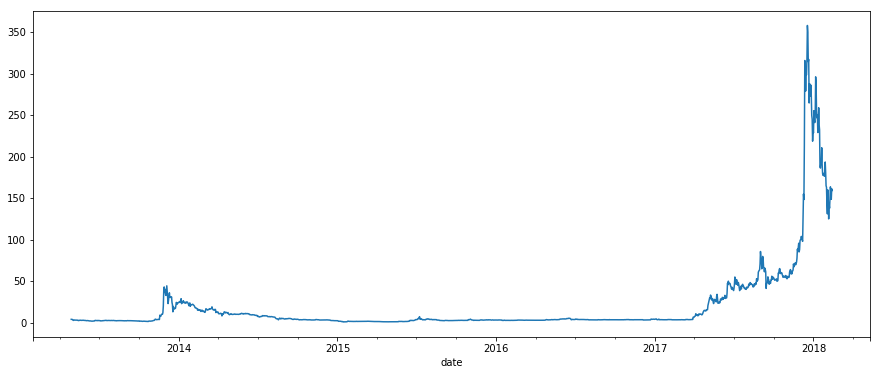

In [36]:
dfCoin = df.loc[df[COL_NAME] == currency]
# only keep close column
sCoin = dfCoin[COL_CLOSE]
sCoin.name = currency
sCoin.plot()
print(sCoin.describe())
sCoin = scale(sCoin)
invScale(sCoin)
pass

## Split into train and test data

In [37]:
train = sCoin[:-forecastWindow]
test = sCoin[-forecastWindow:]

## Forecast time serie

In [38]:
def plotFc(title, train, test, pred):
    train, test, pred = invScale(train), invScale(test), invScale(pred)
    rmse = math.sqrt(mean_squared_error(test, pred))
    plt.plot(train, label="train", color="blue")
    plt.plot(test, label="test", color="yellow")
    plt.plot(pred, label="forecast", color="red")
    plt.legend(loc="best")
    plt.title("{} (RMSE: {:0.2f})".format(title, rmse))
    plt.show()

### Forecast using latest sample
Assume the time serie stays constant for future samples

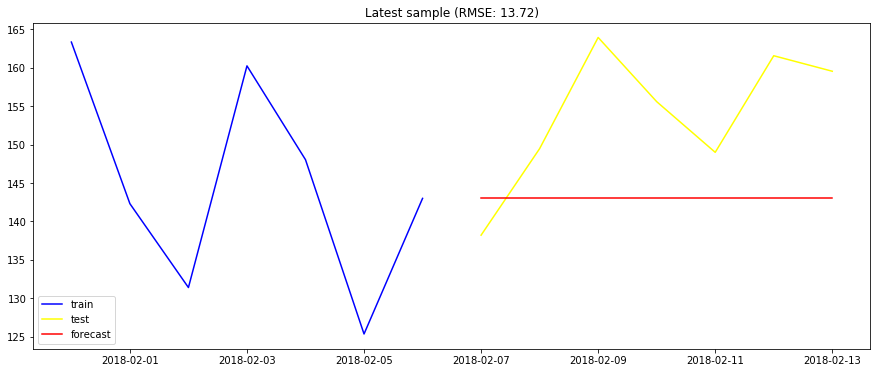

In [39]:
sFc = pd.Series(np.full((forecastWindow), train[-1]), index=test.index)
plotFc("Latest sample", train[-forecastWindow:], test, sFc)

### Forecast using latest average
Average over latest n samples, assume serie stays constant in future.

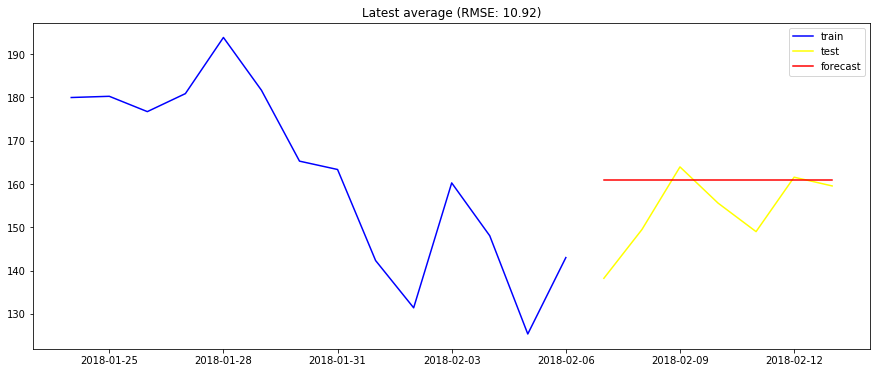

In [40]:
n = lookBack
avg = train[-n:].mean()
sFc = pd.Series(np.full((forecastWindow,), avg), index=test.index)
plotFc("Latest average", train[-n:], test, sFc)

### Moving average over latest samples
Rolling/Moving average over latest n sample, future changes over time

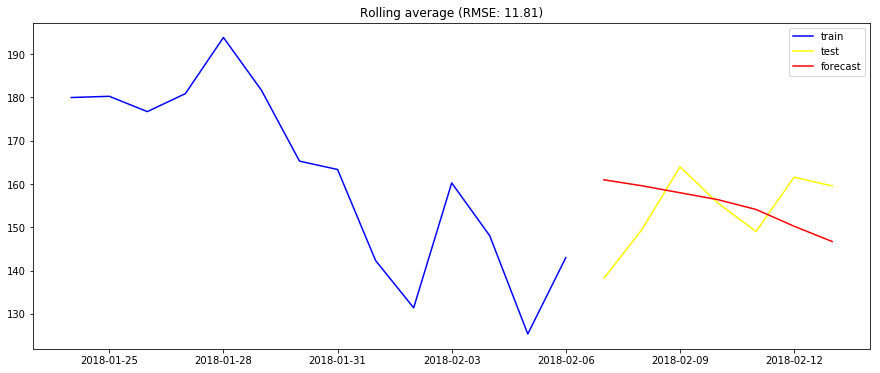

In [41]:
n = lookBack
cA = np.array(train[-n:])
rAvgs = []
for _ in range(forecastWindow):
    avg = cA.mean()
    rAvgs.append(avg)
    cA = cA[1:]
    np.append(cA, [avg])
sFc = pd.Series(rAvgs, index=test.index)
plotFc("Rolling average", train[-n:], test, sFc)

### Exponential weighted moving average
Use EWM forecast.

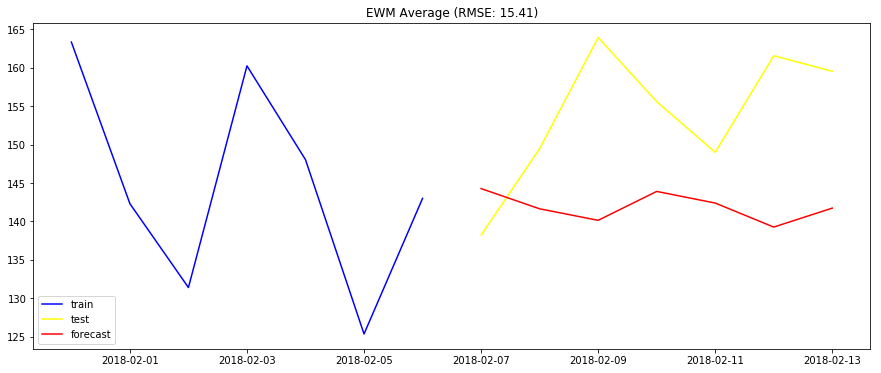

In [42]:
alpha = 0.25
cS = train[-forecastWindow:]
avgs = []
for idx in range(forecastWindow):
    ewm = cS.ewm(alpha=alpha, adjust=False).mean()
    avg = ewm[-1]
    avgs.append(avg)
    cS = cS.append(pd.Series([avg], index=[test.index[idx]]))
    cS = cS[1:]
sFc = cS[-forecastWindow:]
plotFc("EWM Average", train[-forecastWindow:], test, sFc)

### Linear Regression
Use linear regression on latest n samples.

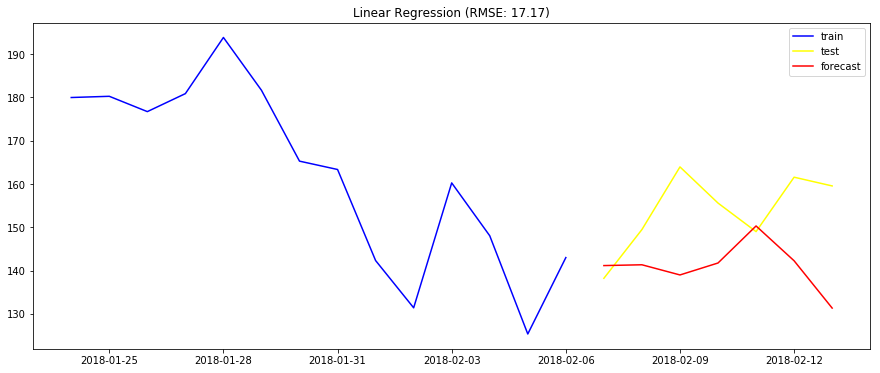

In [43]:
n = lookBack
model = LinearRegression(n_jobs=4)
x = train[-2*n:-n].values.reshape(n, 1)
y = train[-n:].values.reshape(n, 1)
model.fit(x, y)
predX = train[-n:-n+forecastWindow].values.reshape(forecastWindow, 1)
predY = model.predict(predX)
sFc = pd.Series(predY.flatten(), index=test.index)
plotFc("Linear Regression", train[-n:], test, sFc)

### ARIMA

In [44]:
# from pyramid.arima import auto_arima
# model = auto_arima(train,
#         start_p=1,
#         start_q=1,
#         max_p=3,
#         max_q=3,
#         m=12,
#         start_P=0,
#         seasonal=True,
#         #d=1,
#         #D=1,
#         trace=True,
#         approximation=True,
#         error_action='ignore',
#         suppress_warnings=True,
#         stepwise=True)
# print(model.summary())
